# 1.1 Start

---



In [1]:
# importing some libraries (not all are currently used)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

import random

# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


# 2.1 Data Analysis

In [2]:
x_data = np.load('x_train_unfiltered.npy')
y_data = np.load('y_train2.npy')

In [3]:
y_data

array([2, 4, 1, ..., 2, 0, 2])

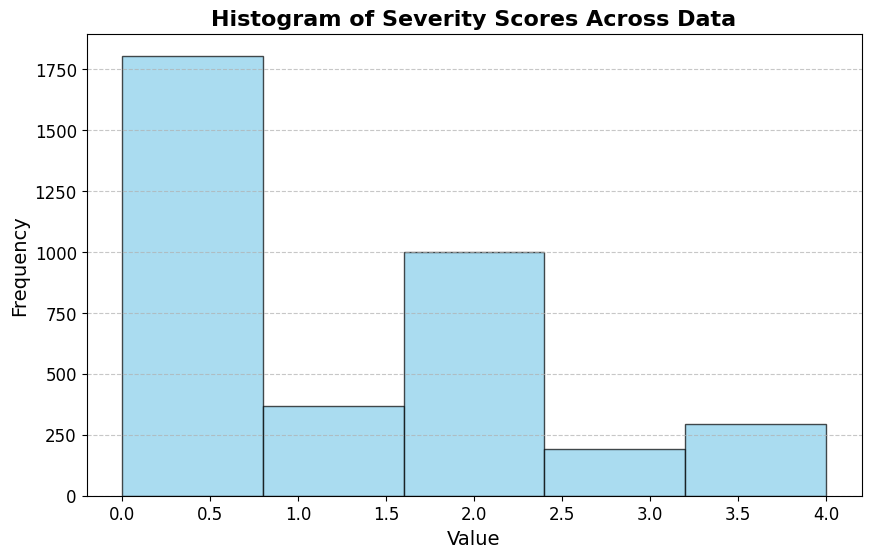

In [4]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_data, bins=5, edgecolor='black', color='skyblue', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Severity Scores Across Data', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [5]:
import numpy as np

def count_occurrences_bincount(arr):
    # Ensure input is a NumPy array of non-negative integers
    if not np.issubdtype(arr.dtype, np.integer) or np.any(arr < 0):
        raise ValueError("Input array must be a NumPy array of non-negative integers.")

    counts = np.bincount(arr)
    return counts

# Example usage
arr = y_data
counts = count_occurrences_bincount(arr)
print(counts)

[1805  370  999  193  295]


([<matplotlib.patches.Wedge at 0x7b3541a48130>,
 [Text(0.024533653067266015, 1.0997263749984245, 'No DR'),
  Text(-1.0593196619831637, -0.29638126414447286, 'Mild'),
  Text(-0.13554444257363468, -1.0916170134655299, 'Moderate'),
  Text(0.8610223192730306, -0.6845732727135142, 'Severe'),
  Text(1.0649610805536351, -0.2754231234047608, 'PR DR')])

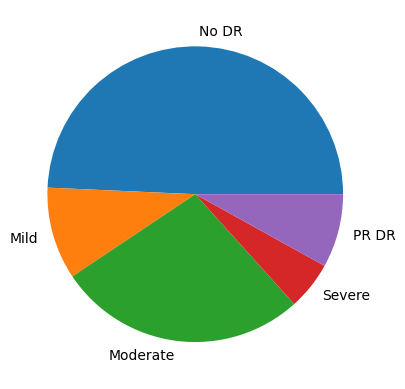

In [6]:
import matplotlib.pyplot as plt

labels = 'No DR', 'Mild', 'Moderate', 'Severe', 'PR DR'
sizes = counts

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

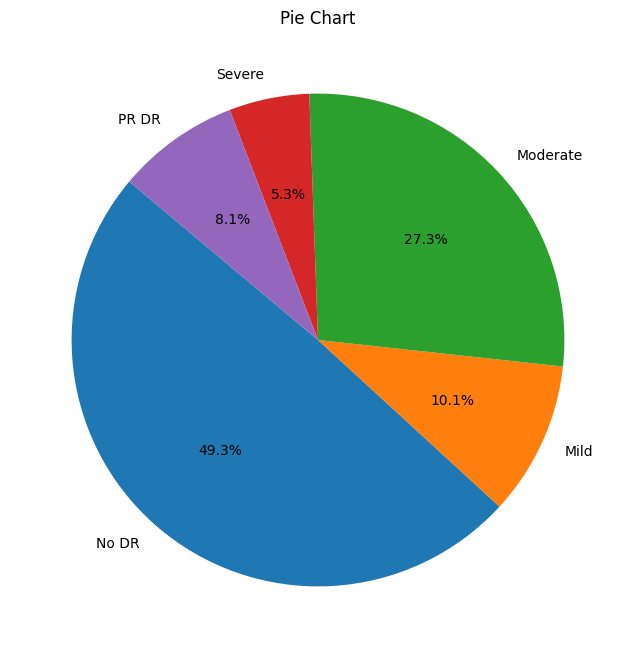

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy array with data for the pie chart
data = counts
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'PR DR']


# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjust the figure size
plt.pie(data, labels=[f'{labels[i]}' for i in range(len(data))], autopct='%1.1f%%', startangle=140)

# Title for the pie chart
plt.title('Pie Chart')

# Show the plot
plt.show()

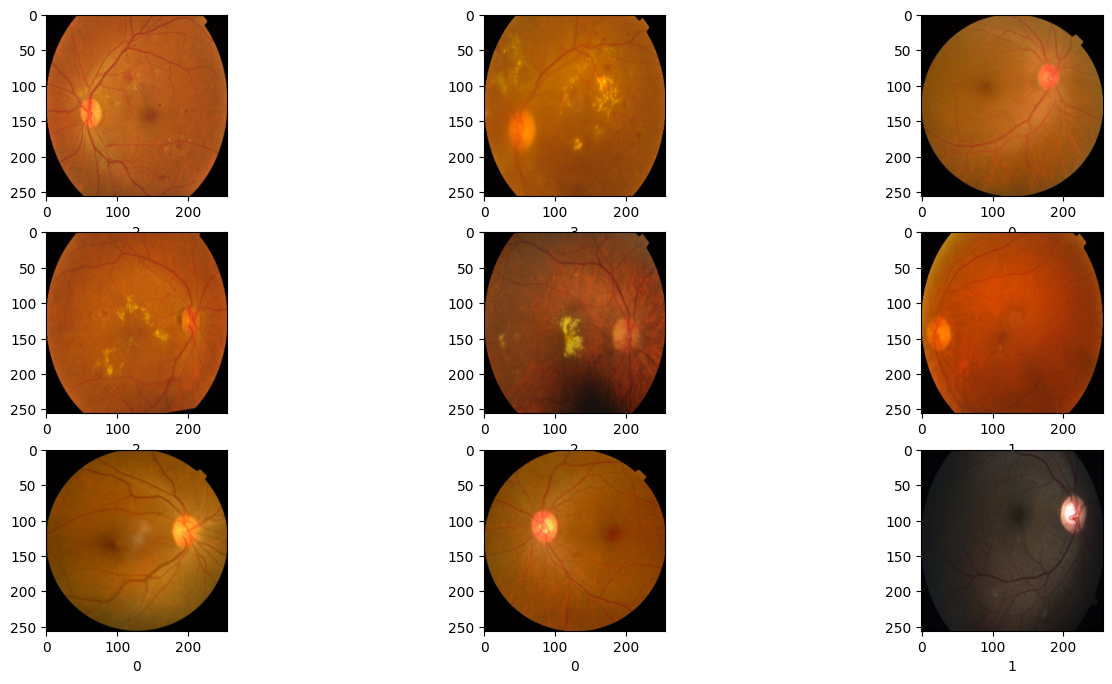

In [8]:
from numpy import random

plt.figure(figsize=(16,8))

arr = random.randint(len(x_data), size=(9))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[arr[i]])
  plt.imshow(x_data[arr[i]])



# 3.1 Data Upload

---



In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [10]:
import torch
from torchvision import transforms
from PIL import Image, ImageFilter
import random

class PreprocessedRetinaDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):

        image = self.x_train[idx]
        label = self.y_train[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


"""transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,)),
])"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.RandomHorizontalFlip(),  # Add random horizontal flipping
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.batch_norm4 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 128)
        self.dropout = nn.Dropout(p=0.001)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))

        x = x.view(-1, 128 * 14 * 14)  # Flatten with the correct size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

#model = EnhancedCNN()

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128) # 32 * 7 * 7, 128
        self.fc2 = nn.Linear(128, 5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        #print("we're here")
        #print(x.shape)
        x = x.view(-1, 32 * 56 * 56) # 32 * 7 * 7
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return x


# Instantiate the model
model = SimpleCNN()

In [13]:
# Create datasets and dataloaders
trainset = PreprocessedRetinaDataset(x_train=x_train, y_train=y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset = PreprocessedRetinaDataset(x_train=x_val, y_train=y_val, transform=transform)
validloader = DataLoader(validset, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 5.1 Training

---



In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [22]:
criterion = FocalLoss(alpha = 1.0, gamma=2.0)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


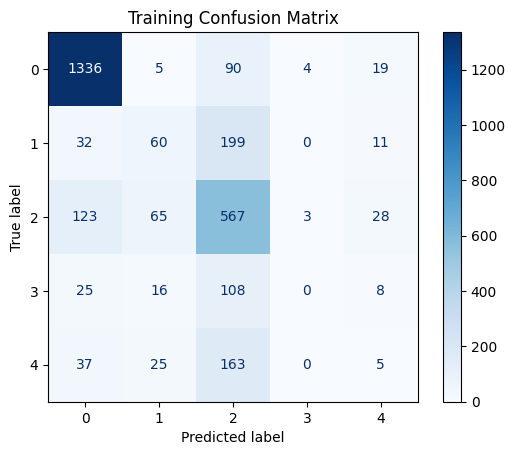

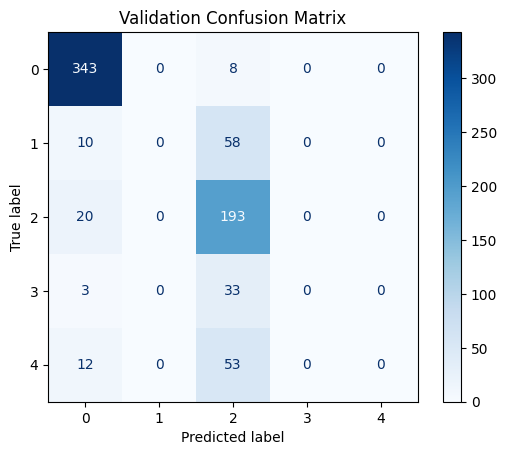

--- 291.28539276123047 seconds ---
Epoch 1: Train Loss: 0.522, Train Accuracy: 67.19%, Valid Loss: 0.466, Valid Accuracy: 73.124%
Train AUROC: 0.798, Train F1: 0.629%, Valid AUROC: 0.836, Valid F1: 0.646%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


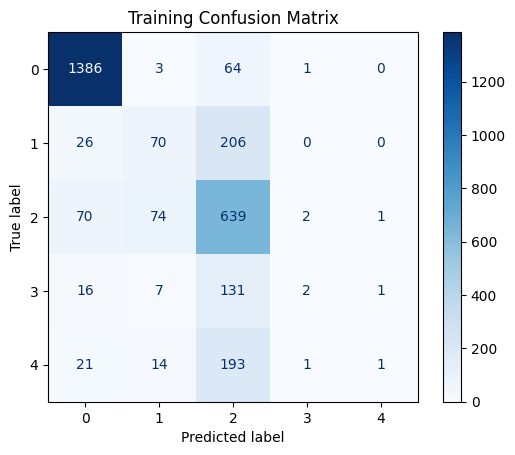

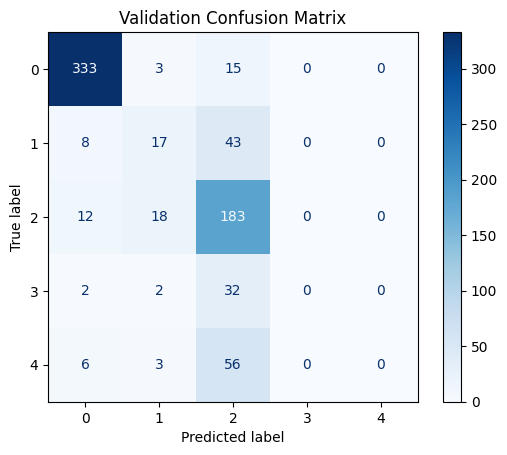

--- 273.9260880947113 seconds ---
Epoch 2: Train Loss: 0.448, Train Accuracy: 71.629%, Valid Loss: 0.441, Valid Accuracy: 72.715%
Train AUROC: 0.836, Train F1: 0.665%, Valid AUROC: 0.838, Valid F1: 0.673%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


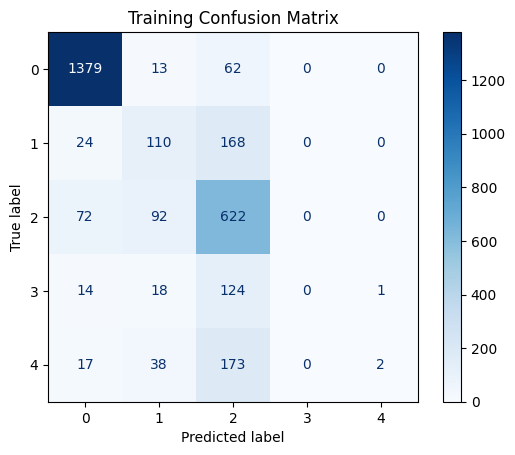

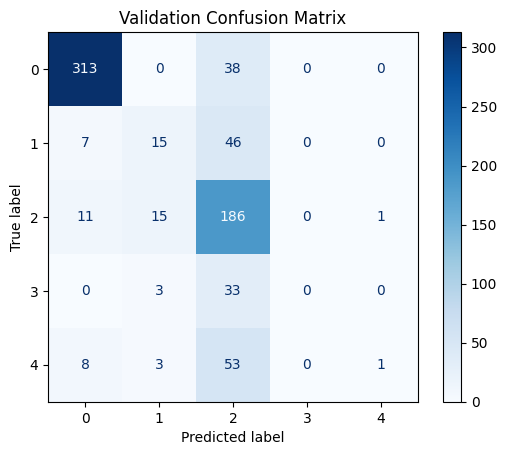

--- 274.4149808883667 seconds ---
Epoch 3: Train Loss: 0.43, Train Accuracy: 72.141%, Valid Loss: 0.459, Valid Accuracy: 70.259%
Train AUROC: 0.847, Train F1: 0.676%, Valid AUROC: 0.839, Valid F1: 0.654%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


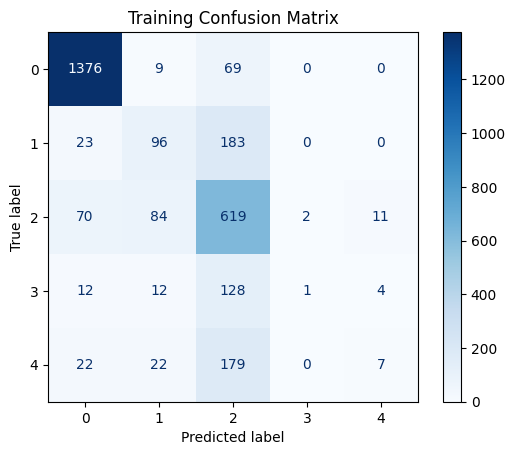

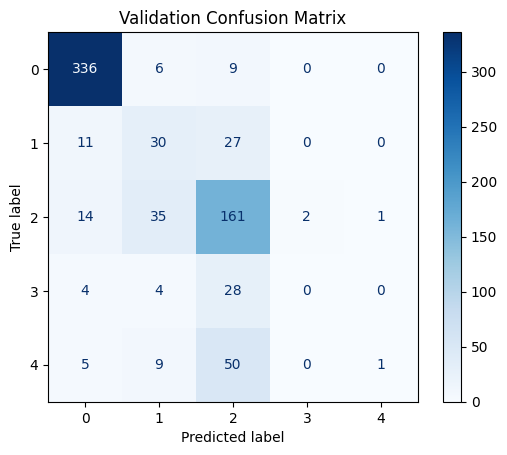

--- 283.9889998435974 seconds ---
Epoch 4: Train Loss: 0.408, Train Accuracy: 71.663%, Valid Loss: 0.436, Valid Accuracy: 72.033%
Train AUROC: 0.864, Train F1: 0.674%, Valid AUROC: 0.847, Valid F1: 0.677%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


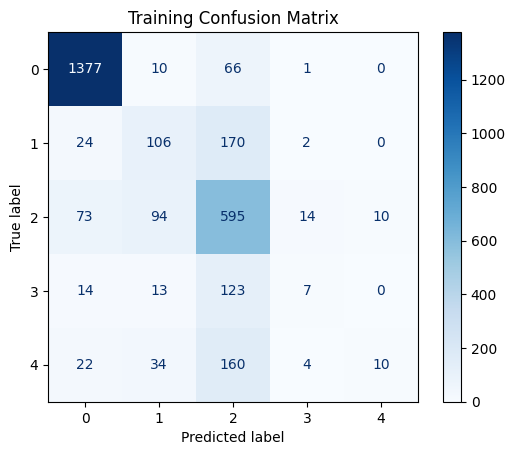

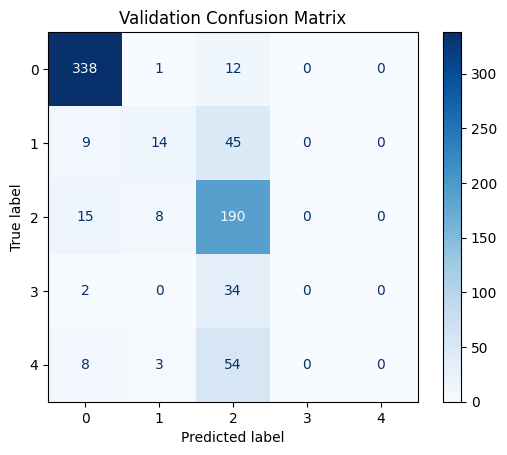

--- 286.5506727695465 seconds ---
Epoch 5: Train Loss: 0.427, Train Accuracy: 71.526%, Valid Loss: 0.431, Valid Accuracy: 73.943%
Train AUROC: 0.852, Train F1: 0.679%, Valid AUROC: 0.847, Valid F1: 0.677%


In [24]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time


def train(model, train_loader, valid_loader, criterion, optimizer, epochs=1):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_f1s, valid_f1s = [], []
    train_auc_scores, train_aurocs = [], []
    valid_auc_scores, valid_aurocs = [], []
    train_tp, train_tn, train_fp, train_fn = [], [], [], []
    valid_tp, valid_tn, valid_fp, valid_fn = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        all_train_labels, all_train_preds = [], []
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # Calculate confusion matrix and TP, TN, FP, FN
        cm = confusion_matrix(all_train_labels, np.argmax(all_train_preds, axis=1), labels=list(range(6)))
        tp, fn, fp, tn = calculate_tp_fn_fp_tn(cm)
        train_tp.append(tp)
        train_tn.append(tn)
        train_fp.append(fp)
        train_fn.append(fn)

        # Calculate AUROC and F1 score
        all_train_labels = np.array(all_train_labels)
        all_train_preds = np.array(all_train_preds)
        train_auroc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovr') if len(np.unique(all_train_labels)) > 1 else float('nan')
        train_f1 = f1_score(all_train_labels, np.argmax(all_train_preds, axis=1), average='weighted')

        # Add to lists
        train_aurocs.append(train_auroc)
        train_f1s.append(train_f1)

        # VALIDATION STEPS
        valid_loss, valid_accuracy, valid_auroc, valid_f1, valid_labels, valid_preds = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_aurocs.append(valid_auroc)
        valid_f1s.append(valid_f1)

        # Plot confusion matrices
        plot_confusion_matrix(np.array(all_train_labels), np.argmax(np.array(all_train_preds), axis=1), title='Training Confusion Matrix')
        plot_confusion_matrix(np.array(valid_labels), np.argmax(np.array(valid_preds), axis=1), title='Validation Confusion Matrix')

        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}: Train Loss: {round(train_loss, 3)}, Train Accuracy: {round(train_accuracy, 3)}%, Valid Loss: {round(valid_loss, 3)}, Valid Accuracy: {round(valid_accuracy, 3)}%")
        print(f"Train AUROC: {round(train_auroc, 3)}, Train F1: {round(train_f1, 3)}%, Valid AUROC: {round(valid_auroc, 3)}, Valid F1: {round(valid_f1, 3)}%")

    return (train_losses, valid_losses, train_accuracies, valid_accuracies,
            train_aurocs, valid_aurocs,
            train_tp, train_tn, train_fp, train_fn,
            valid_tp, valid_tn, valid_fp, valid_fn)

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_valid_labels, all_valid_preds = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    # Calculate AUROC and F1 score
    all_valid_labels = np.array(all_valid_labels)
    all_valid_preds = np.array(all_valid_preds)
    valid_f1 = f1_score(all_valid_labels, np.argmax(all_valid_preds, axis=1), average='weighted')
    valid_auroc = roc_auc_score(all_valid_labels, all_valid_preds, multi_class='ovr') if len(np.unique(all_valid_labels)) > 1 else float('nan')

    # Calculate confusion matrix and TP, TN, FP, FN
    cm = confusion_matrix(all_valid_labels, np.argmax(all_valid_preds, axis=1), labels=list(range(6)))
    valid_tp, valid_fn, valid_fp, valid_tn = calculate_tp_fn_fp_tn(cm)

    return valid_loss, valid_accuracy, valid_auroc, valid_f1, all_valid_labels, all_valid_preds

def calculate_tp_fn_fp_tn(cm):
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    return tp, fn, fp, tn

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(5)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(5)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies, train_aurocs, valid_aurocs, train_tp, train_tn, train_fp, train_fn, valid_tp, valid_tn, valid_fp, valid_fn = train(model, trainloader, validloader, criterion, optimizer, epochs=5)


In [ ]:
torch.save(model, 'Model_CNN_Focal.pt')

In [ ]:
6# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()